In [1]:
from functools import partial

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrng 

from jax import Array

import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

In [2]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations

key = jrng.key(seed)
key, O_key, mu_key = jrng.split(key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.5 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.3 * jnp.eye(n, k=1)
T = T + 0.1 * jnp.eye(n, k=-1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(- 5 * jnp.arange(0, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jrng.uniform(O_key, (n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


# Likelihood computation of a sequence

We now look at the likelihood of a sequence of observations $o_1, \dots, o_T$ given a set of parameters $T, O, \mu$

In [3]:
from generation import generate_sequence, generate_sequence_choice

generate_sequence(jrng.key(0), T, O, mu, 100)
generate_sequence_choice(jrng.key(0), T, O, mu, 100)

%timeit generate_sequence(jrng.key(0), T, O, mu, 100)
%timeit generate_sequence_choice(jrng.key(0), T, O, mu, 100)


904 μs ± 113 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.31 ms ± 2.15 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
n_sequences = 200_000
len_sequence = 20

key = jrng.key(seed)
key, *sequence_keys = jrng.split(key, 1 + n_sequences)

states, observations = jax.vmap(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))(jnp.array(sequence_keys))

In [5]:
from likelihoods import likelihood

# test_sequence = observations[5, ...]
test_sequence = jnp.zeros_like(observations[0, ...]).at[-1].set(1)
test_sequence = jnp.zeros_like(observations[0, ...])

state_likelihoods, llhood_vec = likelihood(test_sequence, T, O, mu, return_stats=True)

In [6]:
from likelihoods import log_likelihood

state_log_likelihoods, log_llhood_vec = log_likelihood(test_sequence, T, O, mu, return_stats=True)

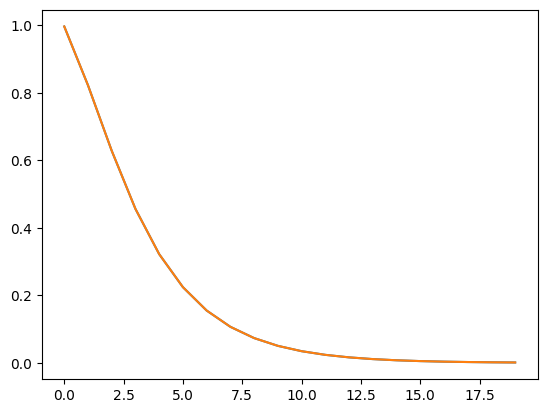

In [7]:
plt.plot(llhood_vec)
plt.plot(jnp.exp(log_llhood_vec))
plt.show()

In [8]:
state_likelihoods, llhood_vec = likelihood(test_sequence, T, O, mu, return_stats=True)

identical_indices = jnp.all(observations == test_sequence, axis=-1)
identical_samples = jnp.sum(identical_indices)

sampled_likelihood = identical_samples / observations.shape[0]

print("Computation was performed as:", log_llhood_vec.dtype)

print(
    "Likelihood sampled:", sampled_likelihood, 
    "\nLikelihood computed:", llhood_vec[-1],
    "\nLog-Likelihood converted:", jnp.exp(log_llhood_vec[-1]))

Computation was performed as: float64
Likelihood sampled: 0.00119 
Likelihood computed: 0.0011703355536235747 
Log-Likelihood converted: 0.0011703355536235747
